In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import misc
from itertools import product, starmap
from PIL import Image
from skimage.transform import resize

plt.rcParams['figure.figsize'] = 15, 10


from functools import partial

def zero_noise(dx):
    return 0

def uniform(a, b, dx):
    return np.random.uniform(a, b, size=dx.shape)

def percent_noise(dx, alpha=2.0):
    return np.random.uniform(-alpha/2*dx, +alpha/2*dx)

def gaussian(dx, mu = 0, var = 1.0):
    return np.random.normal(loc = mu, scale = var)
    

def simulate_input(deltas, noise_fn=zero_noise, prepend_zero=True):
    path = np.zeros(deltas.shape)
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
    
    if prepend_zero:
        return np.concatenate((np.zeros((1,2)), path), axis=0)
    else:
        return path


25x25 image:
[[    0.   16256.25 65025.  ]
 [16256.25     0.   16256.25]
 [65025.   16256.25     0.  ]]

100x100 image:
[[    0.   16256.25 65025.  ]
 [16256.25     0.   16256.25]
 [65025.   16256.25     0.  ]]

250x250 image:
[[    0.   16256.25 65025.  ]
 [16256.25     0.   16256.25]
 [65025.   16256.25     0.  ]]


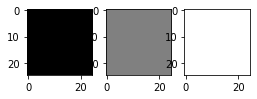

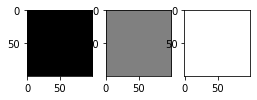

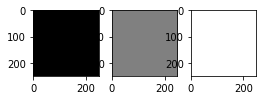

In [163]:
def imread(path, grayscale=False):
    if grayscale:
        img = np.array(Image.open(path).convert('L'))
    else:
        img = np.array(Image.open(path))
    
    return np.swapaxes(img, 0, 1)

def imshow(img, ax=None, grayscale=False, **kwargs):
    if grayscale:
        kwargs['cmap'] = 'gray'
        kwargs['vmin'] = 0
        kwargs['vmax'] = 255
    
    img = np.swapaxes(img, 0, 1) # Convert back to (y,x)
    if img.ndim == 3: # RBG color
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)
    else:
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)

'''
    Returns a square slice of IMG with shape RADIUS*2 X RADIUS*2 
    with the point (X_CENTER, Y_CENTER) in the middle. 
'''
def sample_square(img, x_center, y_center, radius):
    return img[x_center - radius : x_center + radius, y_center - radius : y_center + radius]


'''
    If X_REF and Y_REF are NONE, TEST_IMG and REF_IMG must have same shape. 
    Can be grayscale n x m x 1 or color n x m x 3
    
    If X_REF and Y_REF are not NONE, take a slice of REF_IMG with 
    the point (X_REF, Y_REF) at the center that is the same shape as TEST_IMG.
    TEST_IMG must be a square.
    
    Returns the MSE difference between TEST_IMG and REF_IMG i.e insensitive to the size of the images
'''
def compare_images(test_img, ref_img, x_ref=None, y_ref=None):
    if x_ref == None and y_ref == None:
        assert test_img.shape == ref_img.shape
    elif x_ref != None and y_ref != None:
        # Take a slice from REF_IMG rather than the whole thing
        ref_img = sample_square(ref_img, x_ref, y_ref, test_img.shape[0] // 2)
    else:
        raise ValueError("X_REF and Y_REF must both be either None or not None.")
        
    # Sum of squares difference
    mse = np.sum(np.square(test_img - ref_img)) / ref_img.size
    return mse

# Test
for N in [25, 100, 250]:
    black_img = np.ones((N, N)) * 255
    white_img = np.zeros((N, N))
    grey_img = (black_img + white_img) / 2

    fig, ax = plt.subplots(1, 3, figsize=(4,4))
    imshow(white_img, ax[0], grayscale=True)
    imshow(grey_img,  ax[1], grayscale=True)
    imshow(black_img, ax[2], grayscale=True)

    print("\n{}x{} image:".format(N, N))
    print(np.fromiter(starmap(compare_images, 
                              product([white_img, grey_img, black_img], 
                                      repeat=2)), 
                      np.float64)
          .reshape((3,3)))

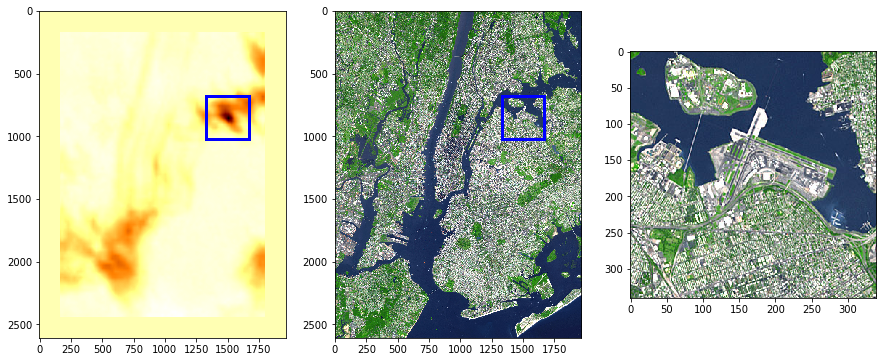

In [269]:
def search_for_match(ref_img, x, y, N, grayscale=False, crop=None, resolution=25):
    if crop != None:
        print("Cropping from shape {} to square of shape {}".format(ref_img.shape, np.ones((crop,crop)).shape))
        ref_img = sample_square(ref_img, x, y, crop//2)
        x = crop//2
        y = crop//2

    
    # Take a sample of size NxN centered at (x,y)
    ref_slice = sample_square(ref_img, x, y, N//2)

    # Display the image and the sample
    # fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    fig, ax = plt.subplots(1, 3)
    imshow(ref_img, ax[1], grayscale=grayscale);
    imshow(ref_slice, ax[2], grayscale=grayscale);
    ax[1].add_patch(Rectangle((x - N//2, y - N//2), N, N, color="blue", fill=False, linewidth=3))

    # Make a heatmap showing the differences between slices taken at each point on the map and the test slice
    x_rng, y_rng = [range(N//2, ref_img.shape[i] - N//2, resolution) for i in (0,1)]
    rect = Rectangle(((x - N//2) , (y - N//2) ), N , N , color="blue", fill=False, linewidth=3)
    errs = np.zeros((len(x_rng), len(y_rng)))
    for (xi,x) in enumerate(x_rng):
        for (yi,y) in enumerate(y_rng):
            test_img = sample_square(ref_img, x, y, N//2)
            errs[xi][yi] = compare_images(test_img, ref_slice)

    # Resize the heatmap to match the original image
    errs = skimage.transform.resize(errs, (ref_img.shape[0] - N, ref_img.shape[1] - N)).copy()
    errs_new = np.ones(ref_img.shape[0:2]) * errs.mean()
    errs_new[N//2:-N//2,N//2:-N//2] = errs
    errs = errs_new

    imshow(errs, ax[0], cmap="afmhot", interpolation='nearest')
    ax[0].add_patch(rect)
    

gs = False
ref_img = imread('manhattan.jpg', grayscale=gs)
x, y = (1500,850)
N = 340
search_for_match(ref_img, x, y, N, grayscale = gs, crop = None)

(1964, 2607, 3) (500, 500, 3)


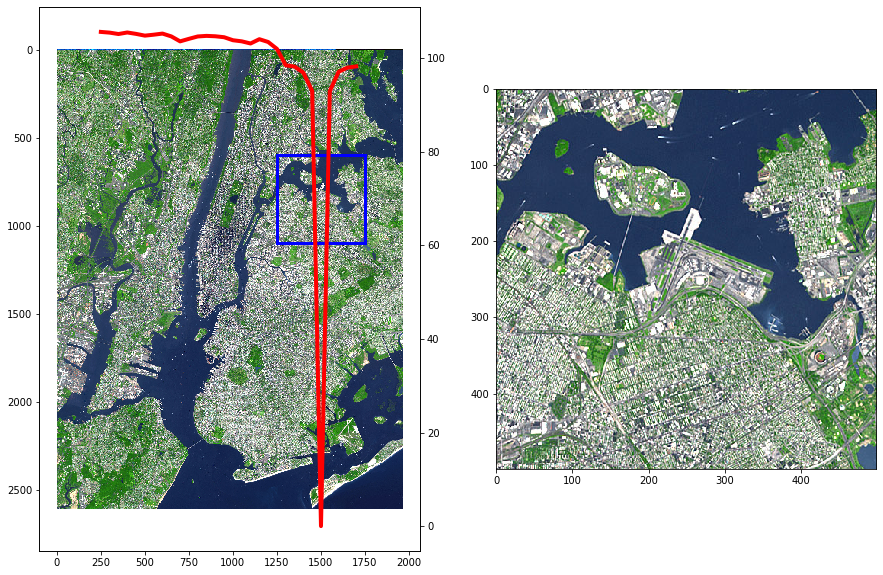

In [263]:
# Same things as above but just across the x axis

ref_img = imread('manhattan.jpg', False)

# Take a sample of size NxN centered at (x,y)
x, y, N = (1500,850,500)
ref_slice = sample_square(ref_img, x, y, N//2)
print(ref_img.shape, ref_slice.shape)

# Display the image and the sample
# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig, ax = plt.subplots(1, 2)
imshow(ref_img, ax[0]);
imshow(ref_slice, ax[1]);
inset = Rectangle((x - N//2, y - N//2), N, N, color="blue", fill=False, linewidth=3)
ax[0].add_patch(inset)

# Take successive slices of REF_IMG along a vertical axis that runs through (x,y) and plot the error 
errs = []
rng = range(N//2, ref_img.shape[0] - N//2, 50)
for i, x in enumerate(rng):
    test_img = sample_square(ref_img, x, y, N//2)
#     print(i,y, test_img.shape)
    errs.append(compare_images(test_img, ref_slice))
errs = np.array(errs)
ax = ax[0].twinx()
ax.plot(rng, errs, 'r', linewidth=4);

In [ ]:

'''
Sample a slice of REF_IMG that is the same shape as TEST_IMG, centered at each location in SEARCH_COORDS.

Return the (x,y) pair that is centered at the slice of REF_IMG that best matches TEST_IMG.
'''
def search(search_coords, test_img, ref_img, threshold=None):
    best_match = 0.0
    best_coords = (None, None)
    for (x,y) in search_coords:
        match = compare_images(test_img, ref_img, x, y)
        if threshold != None and match > threshold:
            return (match, (x, y))
        if match > best_match:
            best_match = match
            best_coords = (x, y)
    return (best_match, best_coords)

In [ ]:
def correct(x, y, true, img, sampradius=10, searchradius=50, threshold = 5):
    bestdiff = 1e99
    bestcoords = (x, y)
    
    # increase sampling as radius increases (concentric squares)
    # measure threshold as percentage of pixels (normalize)
    # conversion from floats to integers
    
    for radius in range(searchradius):
        for angle in np.linspace(0, 2 * np.pi, 50):
            xtest = int(x + radius * np.cos(angle / 50 ))
            ytest = int(y + radius * np.sin(angle / 50))
            diff = np.sum(np.square(true - sampleAt(xtest, ytest, img, sampradius)))
            if diff < bestdiff:
                bestdiff = diff
                bestcoords = (xtest, ytest)
            if diff < threshold:
                return (xtest, ytest)
            
    return np.array(bestcoords)

In [ ]:
def simulateWithCorrections(deltas, img, noise_fn=zero_noise):
    path = np.zeros(deltas.shape)
    camerapos = np.zeros(deltas.shape)
    
    
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
        camerapos[i] = camerapos[i-1] + deltas[i]
        
        if i % 100 == 0 and i != 0:
            sampradius = 10
            if camerapos[i,0] < sampradius\
            or camerapos[i,1] < sampradius\
            or camerapos[i,0] + sampradius >= img.shape[0]\
            or camerapos[i,1] + sampradius >= img.shape[1]: 
                pass
            else:
                path[i] = correct(path[i,0], path[i,1], sampleAt(int(camerapos[i,0]), int(camerapos[i,1]), img, sampradius), img)
    return path

In [ ]:
import skimage as ski

img = ski.io.imread('manhattan.jpg', as_gray = True)
fig, ax = plt.subplots()
ax.imshow(img, cmap='Greys')



xdeltas = np.ones(((np.min(img.shape)), 1))
ydeltas = np.ones(((np.min(img.shape), 1)))

deltas = np.hstack((xdeltas, ydeltas))

path = simulate_input(deltas)


simulated_paths = []

ax.plot(path[0,:], path[1,:], linewidth=1, color='red')


for i in range(10):
    simulated = simulate_input(deltas, percent_noise)
    
    corrected = simulateWithCorrections(deltas, img, percent_noise)
    
    ax.plot(simulated[:,0], simulated[:,1], 'b', alpha=0.4)
    ax.plot(corrected[0,:], corrected[1,:], 'g', alpha=0.5)



In [ ]:
corrected[0,:]